# rme run_30min_ext

In [1]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import calendar
import os

In [2]:
site = 'rme'
site_longname = 'Reynolds Mountain East, Idaho, USA'
y_start = 1988
y_end = 2008

labels = [
    'PHYS_ALL_SUBLI_COMPAC_calonne',
    'PHYS_ALL_SUBLI_CORRECT_COMPAC_calonne',
]

root_path = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowMIP/'+site+'/'
paths = [root_path+'run_'+label for label in labels]

# ds_yr_list = [xr.open_mfdataset(path+'/*_annually.nc').squeeze().load() for path in paths]
# ds_mo_list = [xr.open_mfdataset(path+'/*_monthly.nc').squeeze().load() for path in paths]
ds_d_list = [xr.open_mfdataset(path+'/*_daily.nc').squeeze().load() for path in paths]
# ds_hh_list = [xr.open_mfdataset(path+'/*_halfhourly.nc').squeeze().load() for path in paths]

In [3]:
path = "/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/"+site
rsfile = xr.open_dataset(path+'/rsfile_spinup-final_Ref_30min_ext.nc')

In [4]:
def assign_center_depth(ds, rsfile):
    layer_c = []
    for i in range(len(rsfile.DELZ)):
        if i == 0:
            layer_c.append(rsfile.DELZ.cumsum().values[i]/2)
        else:
            layer_c.append(rsfile.DELZ.cumsum().values[i-1] + rsfile.DELZ.values[i]/2)
    with xr.set_options(keep_attrs=True):
        ds = ds.assign_coords(layer=ds.layer*0+layer_c)
    return ds

In [5]:
for i in range(len(labels)):
    # ds_yr_list[i] = assign_center_depth(ds_yr_list[i], rsfile)
    # ds_mo_list[i] = assign_center_depth(ds_mo_list[i], rsfile)
    ds_d_list[i] = assign_center_depth(ds_d_list[i], rsfile)
    # ds_hh_list[i] = assign_center_depth(ds_hh_list[i], rsfile)

In [6]:
# Paul's SnowMIP data

path_paul = '/home/lalandmi/Dropbox/data/SnowMIP/Paul/CLASS_Results'
label_paul = "SnowMIP"

df_paul = pd.read_csv(path_paul+'/CLASS_sv_REF_'+site+'_'+str(y_start)+'_'+str(y_end)+'.txt', delim_whitespace=True)
df_paul.index = pd.to_datetime(df_paul[['year', 'month', 'day', 'hour']]).values
df_paul= df_paul.drop(columns=['year', 'month', 'day', 'hour'])
df_paul.albsn = df_paul.albsn.replace({0 : np.nan})
df_paul.albs = df_paul.albs.replace({0 : np.nan})
df_paul.tsn = df_paul.tsn.replace({-999 : np.nan})
df_paul.tsns = df_paul.tsns.replace({-999 : np.nan})
ds_paul_h = df_paul.to_xarray()
ds_paul_h = ds_paul_h.rename({'index': 'time'})
ds_paul_h.load()

ds_paul_d = ds_paul_h.resample(time='D').mean().load()
ds_paul_d = ds_paul_d.assign_coords(layer=[0.05 , 0.225, 2.225]) # center of Paul's soil layers (DELZ = [0.1, 0.25, 3.75])

In [7]:
# Combine the soil temperature in one variable
ds_paul_d = ds_paul_d.assign(
    tsl=(('layer', 'time'), [
        list(ds_paul_d['tsl:1'].values),
        list(ds_paul_d['tsl:2'].values),
        list(ds_paul_d['tsl:3'].values),
    ])
)

Text(0.5, 0.98, 'Reynolds Mountain East, Idaho, USA')

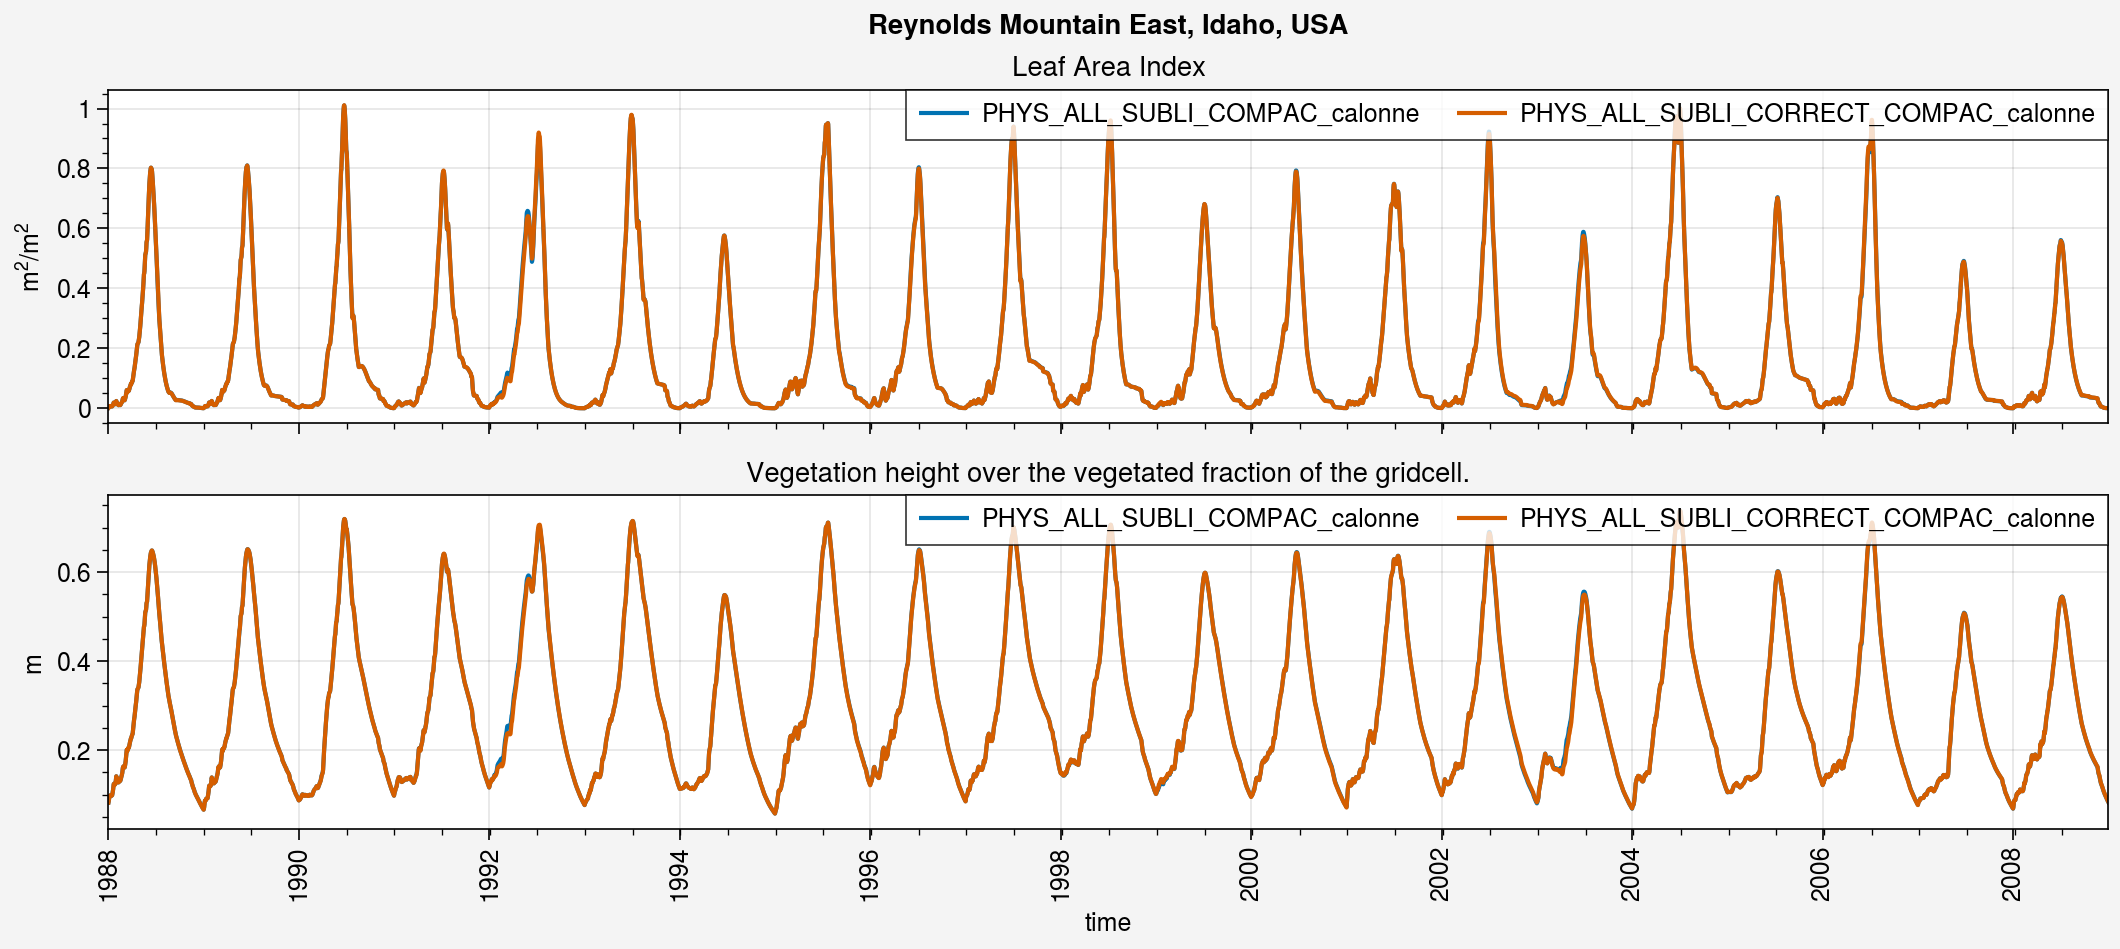

In [8]:
fig, axs = pplt.subplots(ncols=1, nrows=2, refaspect=6, refwidth=10, sharey=0)

for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.lai, label=label)
    axs[1].plot(ds_d.vegHeight, label=label)

axs[0].format(ylabel=ds_d_list[0].lai.units, title=ds_d_list[0].lai.long_name)
axs[1].format(ylabel=ds_d_list[0].vegHeight.units, title=ds_d_list[0].vegHeight.long_name)

for ax in axs:
    ax.legend()

fig.suptitle(site_longname)

Text(0.5, 0.98, 'Reynolds Mountain East, Idaho, USA (1988-2008)')

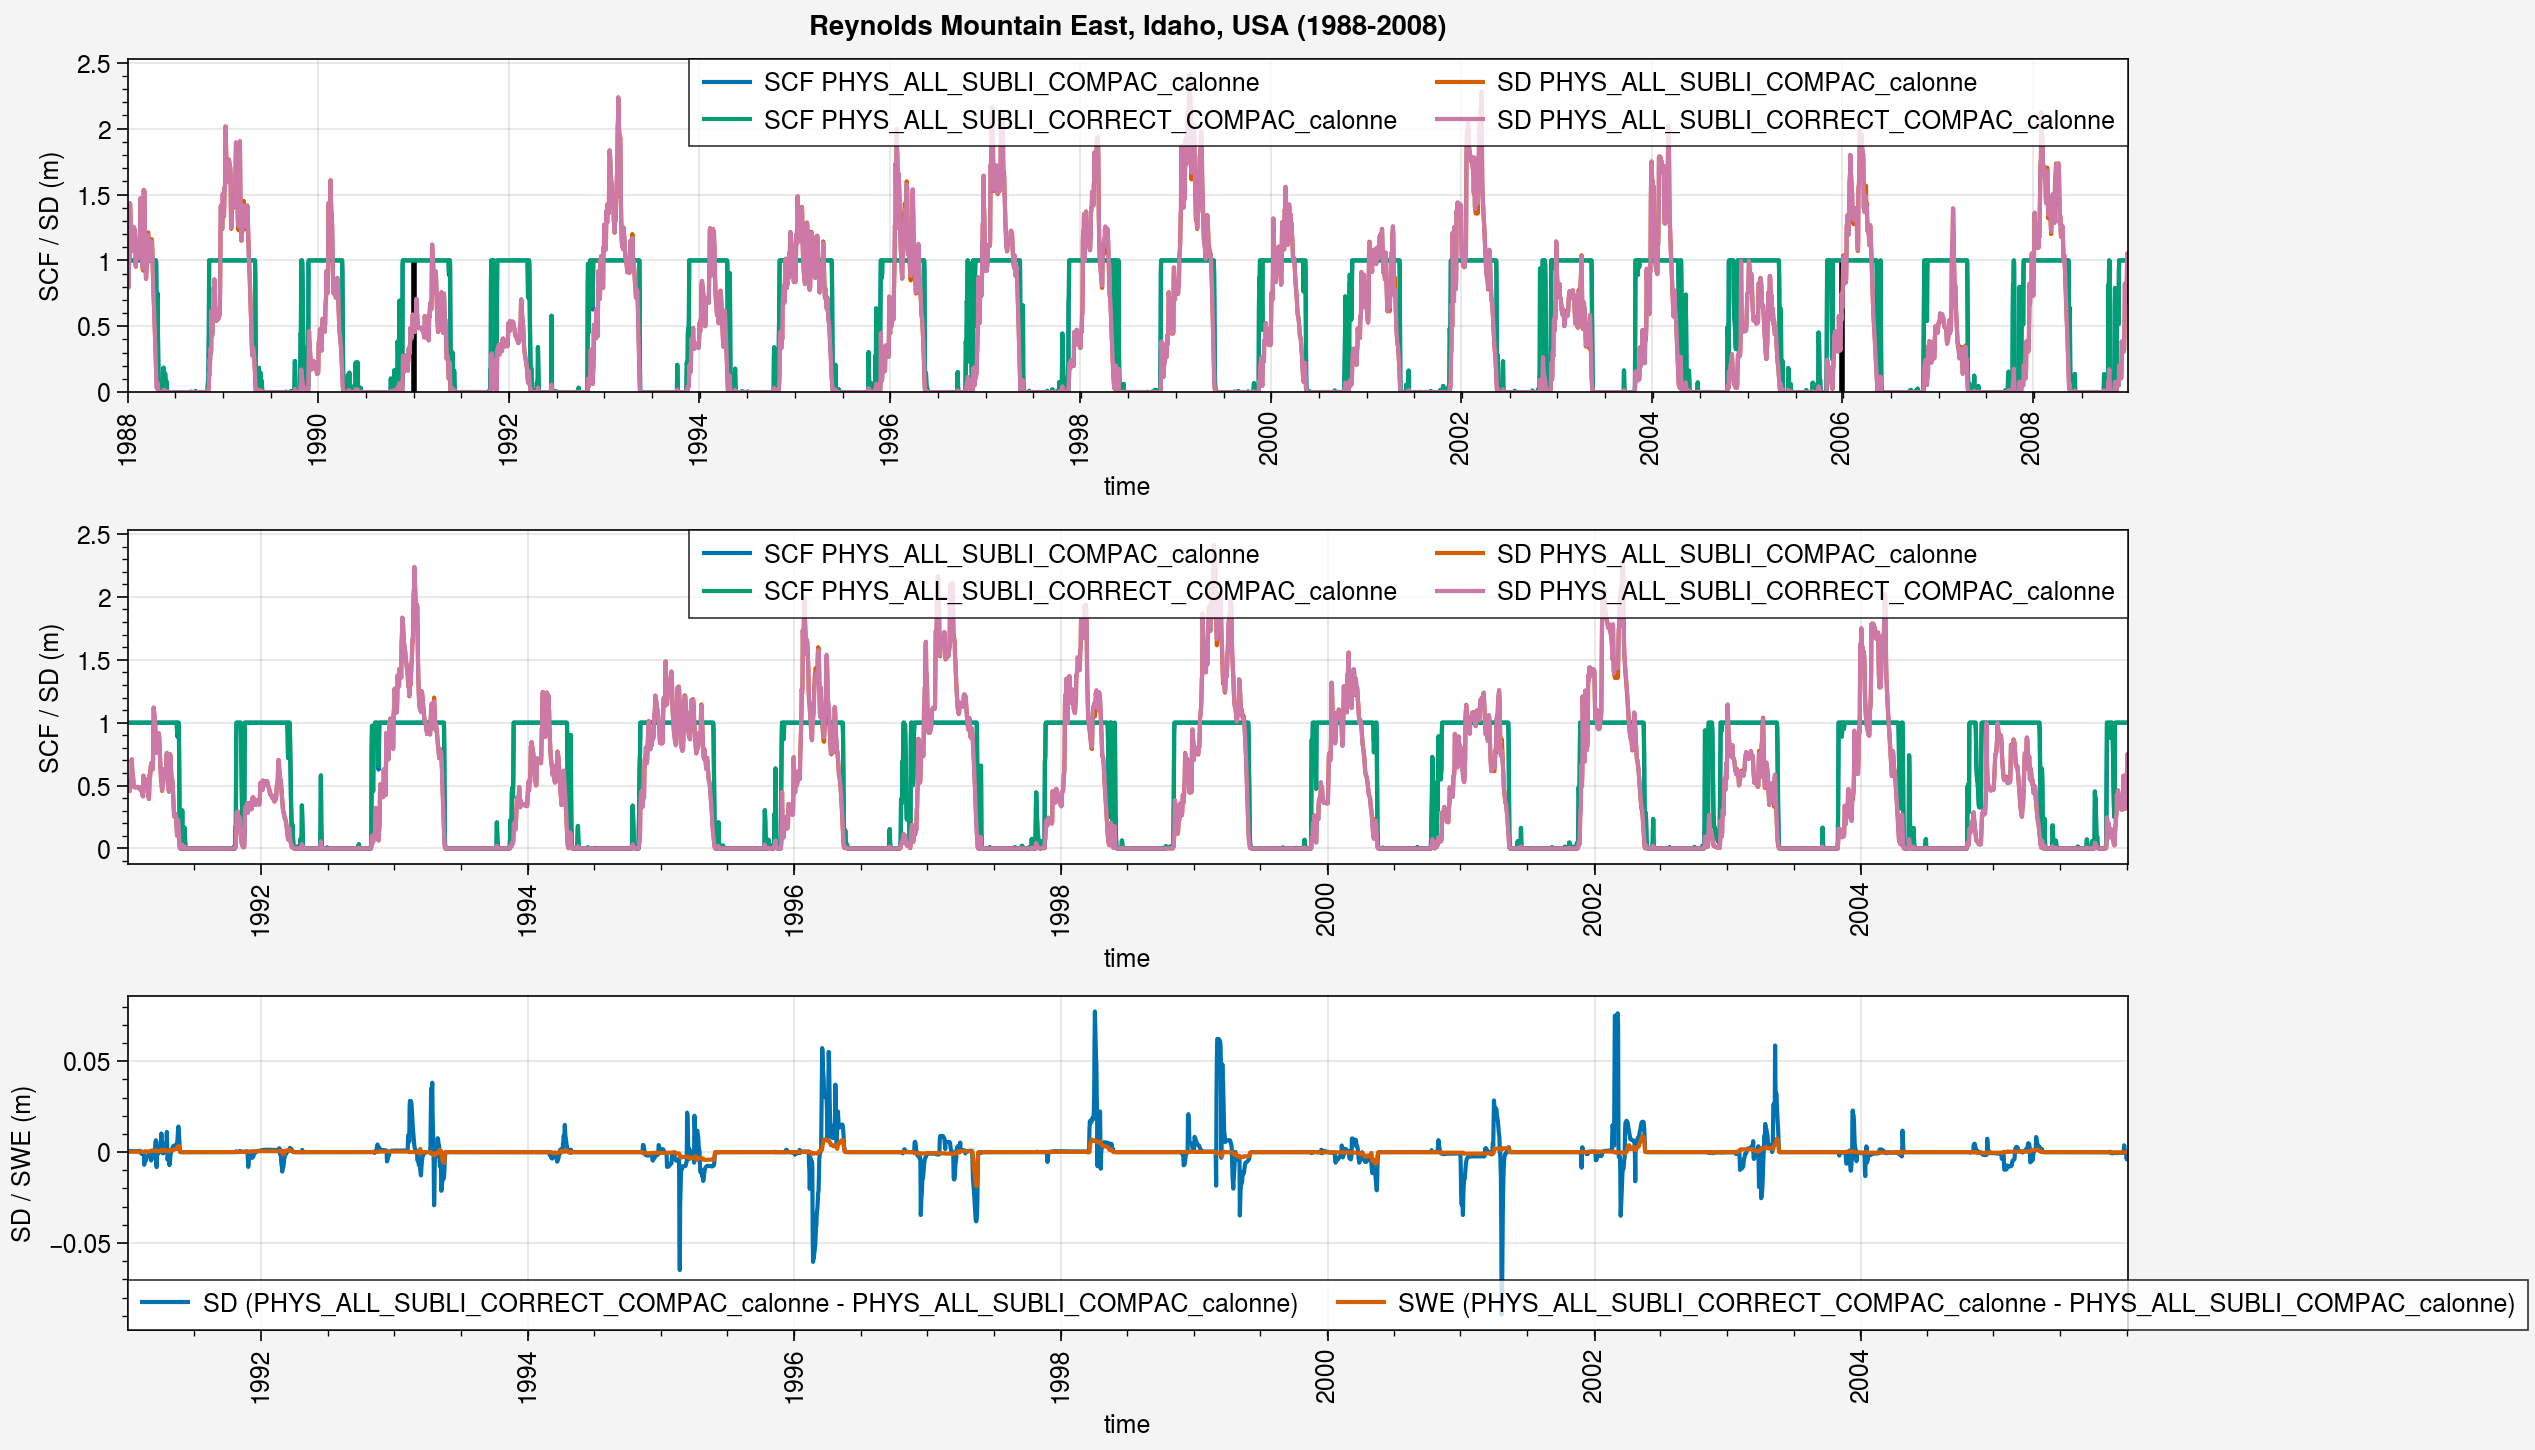

In [9]:
if len(labels) > 1:
    nrows = 3
else: 
    nrows = 2
    
fig, axs = pplt.subplots(ncols=1, nrows=nrows, refaspect=6, refwidth=10, share=0)

##################
### All period ###
##################
start = str(y_start)
end = str(y_end)

for ds_d, label in zip(ds_d_list, labels):
    axs[0].plot(ds_d.snc.sel(time=slice(start,end)), label='SCF '+label)
    axs[0].plot(ds_d.snd.sel(time=slice(start,end)), label='SD '+label)

axs[0].legend(ncols=2, loc='ur')
axs[0].format(
    ylabel='SCF / SD (m)'
)


############
### Zoom ###
############
start = str(y_start+3)
end = str(y_end-3)

for ds_d, label in zip(ds_d_list, labels):
    axs[1].plot(ds_d.snc.sel(time=slice(start,end)), label='SCF '+label)
    axs[1].plot(ds_d.snd.sel(time=slice(start,end)), label='SD '+label)

axs[0].vlines(ds_d_list[0].sel(time=slice(start,end)).time[0], ds_d_list[0].snc.min(), ds_d_list[0].snc.max(), color='k', lw=2)
axs[0].vlines(ds_d_list[0].sel(time=slice(start,end)).time[-1], ds_d_list[0].snc.min(), ds_d_list[0].snc.max(), color='k', lw=2)

axs[1].legend(ncols=2, loc='ur')
axs[1].format(
    ylabel='SCF / SD (m)'
)

if nrows == 3:
    #####################
    ### SWE / SD diff ###
    #####################
    axs[2].plot((ds_d_list[1]-ds_d_list[0]).snd.sel(time=slice(start,end)), label='SD ('+labels[1]+' - '+labels[0]+')')
    axs[2].plot(((ds_d_list[1]-ds_d_list[0]).snw*1e-3).sel(time=slice(start,end)), label='SWE ('+labels[1]+' - '+labels[0]+')')
    
    axs[2].legend(ncols=2)
    axs[2].format(
        ylabel='SD / SWE (m)'
    )

fig.suptitle(site_longname+' ('+str(y_start)+'-'+str(y_end)+')')


In [10]:
for period in [
    slice(str(y_start)+'-08-01', str(y_start+1)+'-07-30'),
]:

    collabels = labels
    for i, (ds, ds_d) in enumerate(zip(ds_hh_list, ds_d_list)):
        
        fig, axs = pplt.subplots(ncols=1, nrows=5, refaspect=6, refwidth=6, sharey=0)
    
        #############################
        ### Fractions of subareas ###
        #############################

        variables = {
            'fcs': {'color': 'blue4', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'fc': {'color': 'green', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'fgs': {'color': 'blue8', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'fg': {'color': 'brown', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
        }

        ax = axs[0]
        for key in variables.keys():
            ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
                    color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
        ax.legend(ncols=1, loc='ul')
        ax.format(ylabel='Fraction of subareas', title='Subareas', ylim=(-0.05,1.05))

        ##############################
        ### Snow related variables ###
        ##############################

        variables = {
            'snd': {'color': 'pastel blue', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'snw': {'color': 'blue6', 'ls': '-', 'lw': 1.5, 'factor': 1e-3*10, 'shift': 0},
            'wsnw': {'color': 'blue6', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
            'scanopy': {'color': 'k', 'ls': '--', 'lw': 1, 'factor': 1e-3*10, 'shift': 0},
            'pr': {'color': 'blue3', 'ls': '-', 'lw': 1, 'factor': 500, 'shift': 0},
        #     'albs': {'color': 'blue6', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
    #         'mrron': {'color': 'blue6', 'ls': '--', 'lw': 1, 'factor': 10, 'shift': 0},
        #     'snm': {'color': 'blue8', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
        }

        ax = axs[1]
        for key in variables.keys():
            ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
                    color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
        ax.plot(ds_d.vegHeight.sel(time=period), label=ds_d.vegHeight.name, color='green', ls='-', lw=1)
        # ax.plot(ds_d.lai.sel(time=period), label='LAI', color='green', ls='-', lw=1)
        ax.legend(ncols=1, loc='ul')
        ax.format(ylabel='m / mm (wsnw, pr) /\ndam (snw/scanopy)', title='Snow')

        variables = {
            'snc': {'color': 'silver', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
        }
        ox = ax.alty(label='Snow Cover Fraction')
        for key in variables.keys():
            ox.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
                    color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
        ox.plot(ds_d.albs.sel(time=period), label='albs', color='yellow7', ls='-', lw=0.8)
        ox.plot(ds_d.albsn.sel(time=period), label='albsn', color='yellow7', ls='--', lw=0.8, alpha=0.5)
        ox.legend(ncols=1, loc='ur')
        ox.format(ylim=(-0.05,1.05))


        ##############################
        ### Surface energy budget ###
        ##############################

        variables = {
            'rss': {'color': 'yellow5', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'rls': {'color': 'orange7', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
        #     'rlds': {'color': 'orange7', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
            'hfss': {'color': 'teal7', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'hfls': {'color': 'cyan6', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'snm': {'color': 'blue6', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 0},
            'uvas': {'color': 'gray', 'ls': '--', 'lw': 1, 'factor': 10, 'shift': 0},
        }

        ax = axs[2]
        for key in variables.keys():
            ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
                    color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
        ax.hlines(0, ds.sel(time=period).time[0], ds.sel(time=period).time[-1], color='k', lw=1, alpha=0.5)
        ax.legend(ncols=1, loc='ul')
        ax.format(ylabel='W m$^{-2}$ /\nuvas (10*m/s)', title='Surface energy budget (+ Energy associated with phase change of water in snow pack)')


        ###################
        ### Temperature ###
        ###################

        variables = {
            'tas': {'color': 'k', 'ls': '--', 'lw': 1, 'factor': 1, 'shift': 273.15},
            'ts': {'color': 'k', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 273.15},    
            'tsn': {'color': 'pastel blue', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
            'tcs': {'color': 'green', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 0},
        }

        ax = axs[3]
        for key in variables.keys():
            ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
                    color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
        ax.plot((ds.tsl-273.15).sel(time=period).isel(layer=0), label=ds.tsl.name+' (0-10cm)', color='dirt')
        ax.plot((ds.tsl-273.15).sel(time=period).isel(layer=1), label=ds.tsl.name+' (10-20cm)', color='gold')
        # ax.plot(ds_h_eval_menard2019.ts.sel(time=period), color='red', label='ts obs')
        ax.hlines(0, ds.sel(time=period).time[0], ds.sel(time=period).time[-1], color='k', lw=1, alpha=0.5)
        ax.legend(ncols=1, loc='ul')
        ax.format(ylabel='°C', title='Temperature')

        


        ############################
        ### Subareas Temperature ###
        ############################

        variables = {
            'ts': {'color': 'k', 'ls': '-', 'lw': 1.5, 'factor': 1, 'shift': 273.15},

            'tsg': {'color': 'brown', 'ls': '--', 'lw': 1.5, 'factor': 1, 'shift': 273.15},
            'tsgs': {'color': 'blue8', 'ls': '--', 'lw': 1.5, 'factor': 1, 'shift': 273.15},
            'tsc': {'color': 'green', 'ls': '--', 'lw': 1.5, 'factor': 1, 'shift': 273.15},
            'tscs': {'color': 'blue4', 'ls': '--', 'lw': 1.5, 'factor': 1, 'shift': 273.15},
        }

        ax = axs[4]
        for key in variables.keys():
            ax.plot(((ds[key]-variables[key]['shift'])*variables[key]['factor']).sel(time=period), label=ds[key].name, 
                    color=variables[key]['color'], ls=variables[key]['ls'], lw=variables[key]['lw'])
        ax.hlines(0, ds.sel(time=period).time[0], ds.sel(time=period).time[-1], color='k', lw=1, alpha=0.5)
        ax.legend(ncols=1, loc='ul')
        ax.format(ylabel='°C', title='Subareas Temperature')

        fig.suptitle(site_longname+' - '+collabels[i])
        fig.format(abc='(a)', abcloc='r')
        # fig.save('img/'+labels[i]+'_hh.jpg')

NameError: name 'ds_hh_list' is not defined

## Check local time

In [ ]:
path_menard2019 = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'
ds_h_met = xr.open_dataset(path_menard2019+'/met_insitu_'+site+'_'+str(y_start)+'_'+str(y_end)+'.nc').load()
period=slice(str(y_start+1)+'-03-14', str(y_start+1)+'-03-18')

In [ ]:
%matplotlib widget
ds_h_met.SWdown.sel(time=period).plot(figsize=(8,4))
ds_hh_list[0].rsds.sel(time=period).plot(marker='.')
ds_hh_list[0].rsds.sel(time=period).resample(time='H').mean().plot(marker='.')

In [ ]:
ds_hh_list[0].rsds.sel(time=period).mean()

In [ ]:
ds_h_met.SWdown.sel(time=period).mean()

In [ ]:
%matplotlib widget
ds_h_met.Tair.sel(time=period).plot(figsize=(8,4), label='Met forcing (local time)')
# ds_hh_list[0].tas.sel(time=period).plot(marker='.')
ds_hh_list[0].tas.sel(time=period).resample(time='H').mean().plot(marker='.', label='CLASSIC halfhourly output')
plt.legend()
plt.title(site_longname)

In [ ]:
%matplotlib widget
(ds_h_met.Rainf + ds_h_met.Snowf).sel(time=period).plot(figsize=(8,4), label='Met forcing (local time)')
# ds_hh_list[0].pr.sel(time=period).plot()
ds_hh_list[0].pr.sel(time=period).resample(time='H').mean().plot(marker='.', label='CLASSIC halfhourly output')

In [ ]:
%matplotlib widget
ds_h_met.LWdown.sel(time=period).plot(figsize=(8,4))
ds_hh_list[0].rlds.sel(time=period).plot(marker='.')
# ds_hh_list[0].rlds.sel(time=period).resample(time='H').mean().plot(marker='.')

## Compare with obs

In [ ]:
path_menard2019 = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'

ds_h_eval_menard2019 = xr.open_dataset(path_menard2019+'/obs_insitu_'+site+'_'+str(y_start)+'_'+str(y_end)+'.nc').load()
ds_d_eval_menard2019 = ds_h_eval_menard2019.resample(time='D').mean().load()
ds_h_eval_menard2019

In [ ]:
tot_year = y_end - y_start + 1
gap = 2
years = pplt.arange(y_start, y_end)
years

### SD

In [ ]:
ds_d_eval_menard2019

In [ ]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-10',str(years[i*gap+gap])+'-05')
    else:
        period=slice(str(years[i*gap])+'-10',str(years[-1])+'-05')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snd.sel(time=period), label=label)

    # SnowMIP
    axs[0].plot(ds_paul_d.snd.sel(time=period), label=label_paul, color='red9')
    
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_eval_menard2019.snd_auto.sel(time=period).values+0.1, axis=0),
        np.expand_dims(ds_d_eval_menard2019.snd_auto.sel(time=period).values-0.1, axis=0),), axis=0)
    axs[0].plot(ds_d_eval_menard2019.snd_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    axs[0].plot(ds_d_eval_menard2019.snd_man.sel(time=period), marker='.', color=color_obs)

    # Veg
    axs[0].plot(ds_d_list[0].vegHeight.sel(time=period), label='vegHeight', color='green', ls='-', lw=0.5, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop)
    
    fig.suptitle(site_longname)


### SWE

In [ ]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-10',str(years[i*gap+gap])+'-05')
    else:
        period=slice(str(years[i*gap])+'-10',str(years[-1])+'-05')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.snw.sel(time=period), label=label)

    # SnowMIP
    axs[0].plot(ds_paul_d.snw.sel(time=period), label=label_paul, color='red9')
    
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_eval_menard2019.snw_auto.sel(time=period).values+25, axis=0),
        np.expand_dims(ds_d_eval_menard2019.snw_auto.sel(time=period).values-25, axis=0),), axis=0)
    axs[0].plot(ds_d_eval_menard2019.snw_auto.sel(time=period), shadedata=shadedata, color=color_obs)
    axs[0].plot(ds_d_eval_menard2019.snw_man.sel(time=period), marker='.', color=color_obs)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='SWE (mm)')
    
    fig.suptitle(site_longname)


### Albedo

In [ ]:
# %matplotlib inline

# color_obs = 'gray8'

# for i in range(tot_year//gap):
#     fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

#     if i*gap+gap < tot_year:
#         period=slice(str(years[i*gap])+'-10',str(years[i*gap+gap])+'-05')
#     else:
#         period=slice(str(years[i*gap])+'-10',str(years[-1])+'-05')
    
#     # Simus
#     k = 0
#     for ds_d, label in zip(ds_d_list, labels):
#         axs[0].plot(ds_d.albs.sel(time=period), label=label+' (albs)', color='C'+str(k))
#         axs[0].plot(ds_d.albsn.sel(time=period), label=label+' (albsn)', color='C'+str(k), ls='--', lw=1)
#         axs[0].plot(ds_d.snc.sel(time=period), label=label+' (SCF)', color='k', alpha=0.5)
        
#         k+=1

#     # SnowMIP
#     axs[0].plot(ds_paul_d.albs.sel(time=period), label=label_paul+' (albs)', color='red9')
#     axs[0].plot(ds_paul_d.albsn.sel(time=period), label=label_paul+' (albsn)', color='red9', ls='--', lw=1)
#     axs[0].plot(ds_paul_d.snc.sel(time=period), label=label_paul+' (SCF)', color='gray6', alpha=0.5)
    
#     # Obs
#     axs[0].plot(ds_d_eval_menard2019.albs.sel(time=period), marker='.', color=color_obs)
    
#     axs[0].legend(loc='ul', ncols=2)
#     axs[0].format(title=period.start+' - '+period.stop, ylabel='Albedo')
    
#     fig.suptitle(site_longname)


### Surface Temperature

In [ ]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-10',str(years[i*gap+gap])+'-05')
    else:
        period=slice(str(years[i*gap])+'-10',str(years[-1])+'-05')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        axs[0].plot(ds_d.ts.sel(time=period)-273.15, label=label)

    # SnowMIP
    axs[0].plot(ds_paul_d.ts.sel(time=period)-273.15, label=label_paul, color='red9')
    
    # Obs
    axs[0].plot(ds_d_eval_menard2019.ts.sel(time=period), marker='.', color=color_obs)
    axs[0].hlines(0, ds_d.ts.sel(time=period).time[0], ds_d.ts.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Surface temperature (°C)')
    
    fig.suptitle(site_longname)


### Soil Temperature

In [ ]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-10',str(years[i*gap+gap])+'-05')
    else:
        period=slice(str(years[i*gap])+'-10',str(years[-1])+'-05')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        # axs[0].plot(((ds_d.tsl.sel(time=period, layer=1)+ds_d.tsl.sel(time=period, layer=2))/2)-273.15, label=label)
        # axs[0].plot(((ds_d.tsl.sel(time=period).isel(layer=0)+ds_d.tsl.sel(time=period).isel(layer=1))/2)-273.15, label=label)
        axs[0].plot(ds_d.tsl.sel(time=period).interp(layer=ds_d_eval_menard2019.sdepth.values).sel(layer=0.3)-273.15, label=label)
    # axs[0].plot(((0.6*ds_paul_d['tsl:1'].sel(time=period)+0.4*ds_paul_d['tsl:2'].sel(time=period)))-273.15, label=label_paul, color='red9')
    axs[0].plot(ds_paul_d.tsl.sel(time=period).interp(layer=ds_d_eval_menard2019.sdepth.values).sel(layer=0.3)-273.15, label=label_paul, color='red9')
        
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.3)+1, axis=0),
        np.expand_dims(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.3)-1, axis=0),), axis=0)
    axs[0].plot(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.3), shadedata=shadedata, marker='.', color=color_obs)
    
    axs[0].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Soil Temp at 30 cm (°C)')
    
    fig.suptitle(site_longname)


In [ ]:
%matplotlib inline

color_obs = 'gray8'

for i in range(tot_year//gap):
    fig, axs = pplt.subplots(ncols=1, nrows=1, refaspect=4, refwidth=10)

    if i*gap+gap < tot_year:
        period=slice(str(years[i*gap])+'-10',str(years[i*gap+gap])+'-06')
    else:
        period=slice(str(years[i*gap])+'-10',str(years[-1])+'-06')
    
    # Simus
    for ds_d, label in zip(ds_d_list, labels):
        # axs[0].plot(((ds_d.tsl.sel(time=period, layer=1)+ds_d.tsl.sel(time=period, layer=2))/2)-273.15, label=label)
        # axs[0].plot(((ds_d.tsl.sel(time=period).isel(layer=0)+ds_d.tsl.sel(time=period).isel(layer=1))/2)-273.15, label=label)
        axs[0].plot(ds_d.tsl.where(ds_d.snd > 0.1).where(ds_d.albs > 0.5).sel(time=period).interp(layer=ds_d_eval_menard2019.sdepth.values)\
                    .sel(layer=0.3)-273.15, label=label, marker='.')
        # axs[0].plot(ds_d.tsl.where(ds_d.snd > 0.1).sel(time=period).interp(layer=ds_d_eval_menard2019.sdepth.values)\
        #             .sel(layer=0.3)-273.15, label=label, marker='.')
    # axs[0].plot(((0.6*ds_paul_d['tsl:1'].sel(time=period)+0.4*ds_paul_d['tsl:2'].sel(time=period)))-273.15, label=label_paul, color='red9')
    # axs[0].plot(ds_paul_d.tsl.where(ds_paul_d.snd > 0.1).sel(time=period).interp(layer=ds_d_eval_menard2019.sdepth.values)\
    #             .sel(layer=0.3)-273.15, label=label_paul, color='red9', marker='.')
        
    # Obs
    # shadedata = np.concatenate((
    #     np.expand_dims(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.3)+1, axis=0),
    #     np.expand_dims(ds_d_eval_menard2019.tsl.sel(time=period, sdepth=0.3)-1, axis=0),), axis=0)
    # axs[0].plot(ds_d_eval_menard2019.tsl.where(ds_d_eval_menard2019.snd_auto > 0.1).sel(time=period, sdepth=0.3), marker='.', color=color_obs)
    
    axs[0].hlines(0, ds_d.tsl.sel(time=period).time[0], ds_d.tsl.sel(time=period).time[-1], c='k', lw=1, alpha=0.5)
    axs[0].legend(loc='ul', ncols=2)
    axs[0].format(title=period.start+' - '+period.stop, ylabel='Soil Temp at 30 cm (°C)')
    
    fig.suptitle(site_longname)
